In [101]:
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd
import networkx as nx
import sqlite3
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap


In [2]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_coor = pd.read_sql("select distinct geometry, cable_id, cable_length from landing_points left join cable_coor on cable_id = id",con=con)
# cable_shap = gpd.GeoDataFrame(cable_coor, crs=4326)

In [3]:
cable_coor

,geometry,cable_id,cable_length
0,MULTILINESTRING ((-74.2052931188053 11.2419380...,colombian-festoon,400.0
1,MULTILINESTRING ((-146.35343293589432 61.13035...,alaska-united-east-au-east,3751.0
2,MULTILINESTRING ((18.701330987741642 59.759755...,sweden-finland-4-sfs-4,254.0
3,MULTILINESTRING ((7.426728974775415 43.7382556...,italy-monaco,162.0
4,MULTILINESTRING ((32.529931191431416 29.972545...,imewe,12091.0
...,...,...,...
505,MULTILINESTRING ((129.92498219586352 -10.01151...,north-west-cable-system,2100.0
506,MULTILINESTRING ((119.92498927995226 18.678647...,tata-tgn-intra-asia-tgn-ia,6700.0
507,MULTILINESTRING ((-88.29445457772995 17.925607...,strategic-evolution-underwater-link-seul,24.0
508,MULTILINESTRING ((-46.328062944825774 -23.9618...,tannat,2000.0


In [4]:
cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")
# coor_list = cleaned_cable_coor.iloc[0].split(', (')
cleaned_cable_coor.iloc[2].split(', (')

index_cable_id = list(cable_coor.columns).index('cable_id')
index_cable_length = list(cable_coor.columns).index('cable_length')


data = pd.DataFrame()

for row in range(cleaned_cable_coor.shape[0]):
    coor_list = cleaned_cable_coor.iloc[row].split(', (')
    cable_id = cable_coor.iloc[row,index_cable_id]
    cable_length = cable_coor.iloc[row,index_cable_length]

    for x in coor_list:
        seg = pd.DataFrame()
        abc = x.split(', ')
        # print(abc)
        for y in abc:
            a = {'lon1': y.split(' ')[0], 'lat1': y.split(' ')[1], 'cable_id': cable_id, 'cable_length': cable_length}
            seg = seg.append(a,ignore_index=True)
        seg["lon1"] = seg["lon1"].astype("float64")
        seg["lat1"] = seg["lat1"].astype("float64")
        seg['lon2'] = seg['lon1'].shift()
        seg['lat2'] = seg['lat1'].shift()
        data = data.append(seg.dropna(),ignore_index=True)
data

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_76547/731251032.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")


,lon1,lat1,cable_id,cable_length,lon2,lat2
0,-74.362373,11.331481,colombian-festoon,400.0,-74.205293,11.241938
1,-74.474873,11.221153,colombian-festoon,400.0,-74.362373,11.331481
2,-74.611933,11.012161,colombian-festoon,400.0,-74.474873,11.221153
3,-75.149873,11.073983,colombian-festoon,400.0,-74.952802,11.005163
4,-75.262372,10.963557,colombian-festoon,400.0,-75.149873,11.073983
...,...,...,...,...,...,...
9325,-50.849890,-34.487754,tannat,2000.0,-47.699892,-32.612760
9326,-53.549888,-35.226267,tannat,2000.0,-50.849890,-34.487754
9327,-54.950187,-34.900416,tannat,2000.0,-53.549888,-35.226267
9328,-53.999888,-35.593029,tannat,2000.0,-53.549888,-35.226267


In [5]:
# data['lon2'] = data['lon1'].shift()
# data['lat2'] = data['lat1'].shift()
# data["lon1"] = data["lon1"].astype("float64")
# data["lat1"] = data["lat1"].astype("float64")

In [6]:
# cable_coor.iloc[0,1]
cable_coor.iloc[2,1]

'sweden-finland-4-sfs-4'

In [7]:
data.dropna()
gdf = gpd.GeoDataFrame(data)
    # data,geometry=gpd.points_from_xy(data.lon1, data.lat1), crs=4326)
gdf['fr_point'] = gpd.points_from_xy(x=gdf['lon1'],y=gdf['lat1'])
gdf['to_point'] = gpd.points_from_xy(x=gdf['lon2'],y=gdf['lat2'])
gdf['fr_id'] = round((round(gdf['lon1'],5) + round(gdf['lat1'],5))*100000,0)
gdf['to_id'] = round((round(gdf['lon2'],5) + round(gdf['lat2'],5))*100000,0)
gdf['distance_from_previous'] = gdf['fr_point'].distance(gdf['to_point'])
gdf['total_distance'] = gdf.groupby('cable_id')['distance_from_previous'].transform('sum')
gdf['length_from_previous'] = gdf['cable_length'] / gdf['total_distance'] * gdf['distance_from_previous']

# gdf['distance_from_previous'] = gdf.distance(gdf.shift(1))

In [8]:
gdf = gdf.iloc[1::,]
gdf['line'] = gdf.apply(lambda row: LineString([row['fr_point'], row['to_point']]), axis=1) #Create a linestring column
geo_df = gpd.GeoDataFrame(gdf, geometry=gdf['line'])

In [9]:
gdf.to_csv("/Users/dijiongyuequ/Downloads/distance.csv")

<AxesSubplot:>

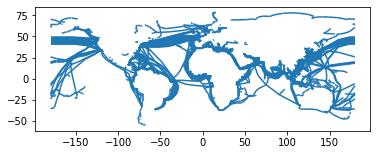

In [10]:
gdf.plot()

In [11]:
gdf = gdf.reset_index( )


In [12]:
gdf.to_csv('/Users/dijiongyuequ/Downloads/345.csv')

In [13]:
gdf.sample(5)

,index,lon1,lat1,cable_id,cable_length,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,line,geometry
9021,9022,17.100062,69.104595,svalbard-undersea-cable-system,2714.0,16.987562,68.862519,POINT (17.10006 69.10460),POINT (16.98756 68.86252),8620466.0,8585008.0,0.266940,LINESTRING (17.10006212209538 69.1045950560622...,"LINESTRING (17.10006 69.10460, 16.98756 68.86252)"
2575,2576,104.175000,0.398835,jakarta-bangka-bintan-batam-singapore-b3js,1031.0,104.850000,0.290337,POINT (104.17500 0.39884),POINT (104.85000 0.29034),10457384.0,10514034.0,0.683664,LINESTRING (104.17500043739219 0.3988350840412...,"LINESTRING (104.17500 0.39884, 104.85000 0.29034)"
5522,5523,2.250073,37.945510,flag-europe-asia-fea,28000.0,-2.249924,36.149867,POINT (2.25007 37.94551),POINT (-2.24992 36.14987),4019558.0,3389995.0,4.845029,LINESTRING (2.250072641967279 37.9455104954597...,"LINESTRING (2.25007 37.94551, -2.24992 36.14987)"
8689,8690,6.862569,62.763923,n0r5ke-viking,810.0,7.160714,62.737229,POINT (6.86257 62.76392),POINT (7.16071 62.73723),6962649.0,6989794.0,0.299337,LINESTRING (6.862569374431217 62.7639233289057...,"LINESTRING (6.86257 62.76392, 7.16071 62.73723)"
7742,7743,-130.556085,54.330299,ketchcan1-submarine-fiber-cable-system,167.0,-130.443585,54.297486,POINT (-130.55608 54.33030),POINT (-130.44358 54.29749),-7622578.0,-7614609.0,0.117188,LINESTRING (-130.55608452595908 54.33029904361...,"LINESTRING (-130.55608 54.33030, -130.44358 54..."


In [44]:
G = nx.from_pandas_edgelist(gdf, 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous'], create_using=nx.Graph)


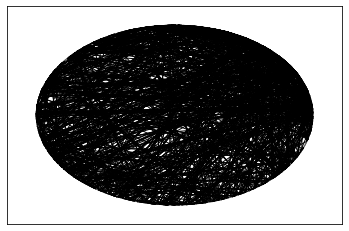

In [45]:
nx.draw_networkx_edges(G, pos=nx.circular_layout(G))


In [46]:
path = nx.shortest_path(G,6181995, 4629267, weight = 'length_from_previous')

# def getPath(path, road):
#     pathroad = pd.DataFrame()
#     for i in range(5):
#         # len(path.keys())-1
#         node1 = path[list (path.keys())[i]]
#         print(node1)
#         node2 = path[list (path.keys())[i+1]]
#         print(node2)
#         r = road[(road['fr_id'] == node1) & (road['to_id'] == node2)]
#         pathroad = pathroad.append(r)
#     return pathroad

def getPath(path, road):
    pathroad = pd.DataFrame()
    for i in range(len(path)-1):
        # len(path.keys())-1
        node1 = path[i]
        node2 = path[i+1]
        # fr_id and to_id might be in opposite order
        r = road[ ((road['fr_id'] == node1) & (road['to_id'] == node2)) | (road['fr_id'] == node2) & (road['to_id'] == node1) ]
        pathroad = pathroad.append(r)
    return pathroad

In [39]:
# path1 = nx.shortest_path(G,6181995, 10373031, weight = 'length')
# path2 = nx.shortest_path(G,2943486, 10373031, weight = 'length')


# set(path1).difference(set(path2))

In [40]:
path

[6181995,
 6137589.0,
 6124767.0,
 6186725.0,
 6191568.0,
 6178972.0,
 6163015.0,
 6176679.0,
 6166635.0,
 6160754.0,
 6117610.0,
 6086531.0,
 6068944.0,
 6077320.0,
 5995276.0,
 5805964.0,
 5564679.0,
 5291555.0,
 4983977.0,
 4838635.0,
 4773860.0,
 4782323.0,
 4816573.0,
 4915742.0,
 4859145.0,
 4847135.0,
 4712280.0,
 4352280.0,
 4001793.0,
 3380905.0,
 3146805.0,
 3029752.0,
 2957695.0,
 2705905.0,
 2652200.0,
 2669559.0,
 2619840.0,
 3055160.0,
 3925431.0,
 4193737.0,
 4423629.0,
 4628380.0,
 4618691.0,
 4629267]

<AxesSubplot:>

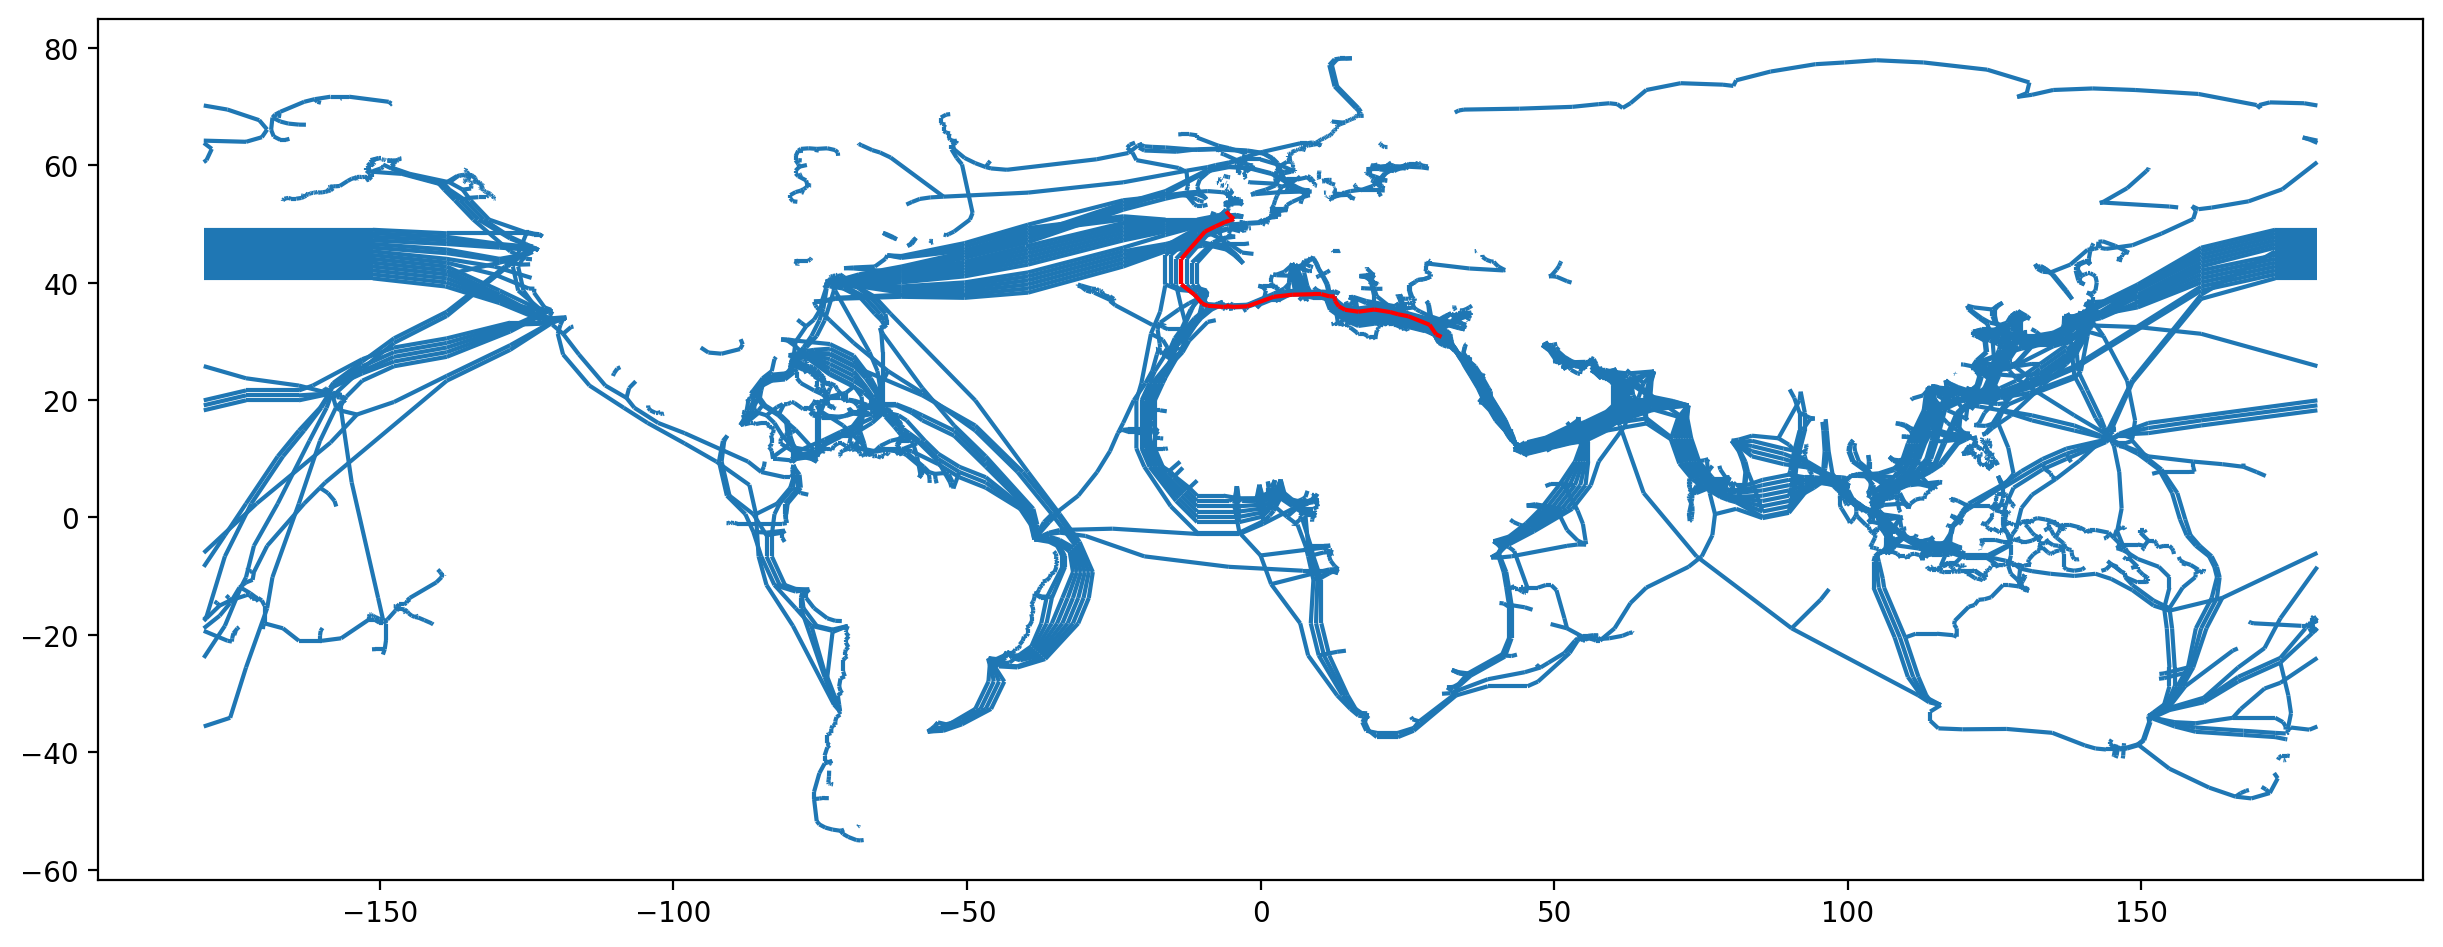

In [47]:
path = nx.shortest_path(G,6158154, 4629267, weight = 'length_from_previous')


fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)

path_road = getPath(path, gdf)
gdf.plot(ax=ax)
path_road.plot(ax = ax, color='red')


In [42]:
path_road.head()

,index,lon1,lat1,cable_id,cable_length,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,line,geometry,total_distance,length_from_previous
5503,5504,30.825052,30.756490,flag-europe-asia-fea,28000.0,29.893513,31.191465,POINT (30.82505 30.75649),POINT (29.89351 31.19147),6158154.0,6108498.0,1.028090,LINESTRING (30.825052399183477 30.756490442252...,"LINESTRING (30.82505 30.75649, 29.89351 31.19147)",251.382733,114.512687
588,589,28.800054,32.812319,seamewe-3,39000.0,29.893513,31.191465,POINT (28.80005 32.81232),POINT (29.89351 31.19147),6161237.0,6108498.0,1.955203,LINESTRING (28.8000538337115 32.81231878328768...,"LINESTRING (28.80005 32.81232, 29.89351 31.19147)",355.922922,214.240002
589,590,25.200056,34.265678,seamewe-3,39000.0,28.800054,32.812319,POINT (25.20006 34.26568),POINT (28.80005 32.81232),5946574.0,6161237.0,3.882297,LINESTRING (25.20005638398345 34.2656775265242...,"LINESTRING (25.20006 34.26568, 28.80005 32.81232)",355.922922,425.399968
590,591,23.400058,34.621321,seamewe-3,39000.0,25.200056,34.265678,POINT (23.40006 34.62132),POINT (25.20006 34.26568),5802138.0,5946574.0,1.834796,LINESTRING (23.400057658523423 34.621321285206...,"LINESTRING (23.40006 34.62132, 25.20006 34.26568)",355.922922,201.046507
591,592,22.050059,34.990810,seamewe-3,39000.0,23.400058,34.621321,POINT (22.05006 34.99081),POINT (23.40006 34.62132),5704087.0,5802138.0,1.399650,LINESTRING (22.05005861487558 34.9908097185758...,"LINESTRING (22.05006 34.99081, 23.40006 34.62132)",355.922922,153.365610


In [48]:
nx.shortest_path_length(G,6181995, 10373031, weight = 'length_from_previous')


9214.791973462634

<AxesSubplot:>

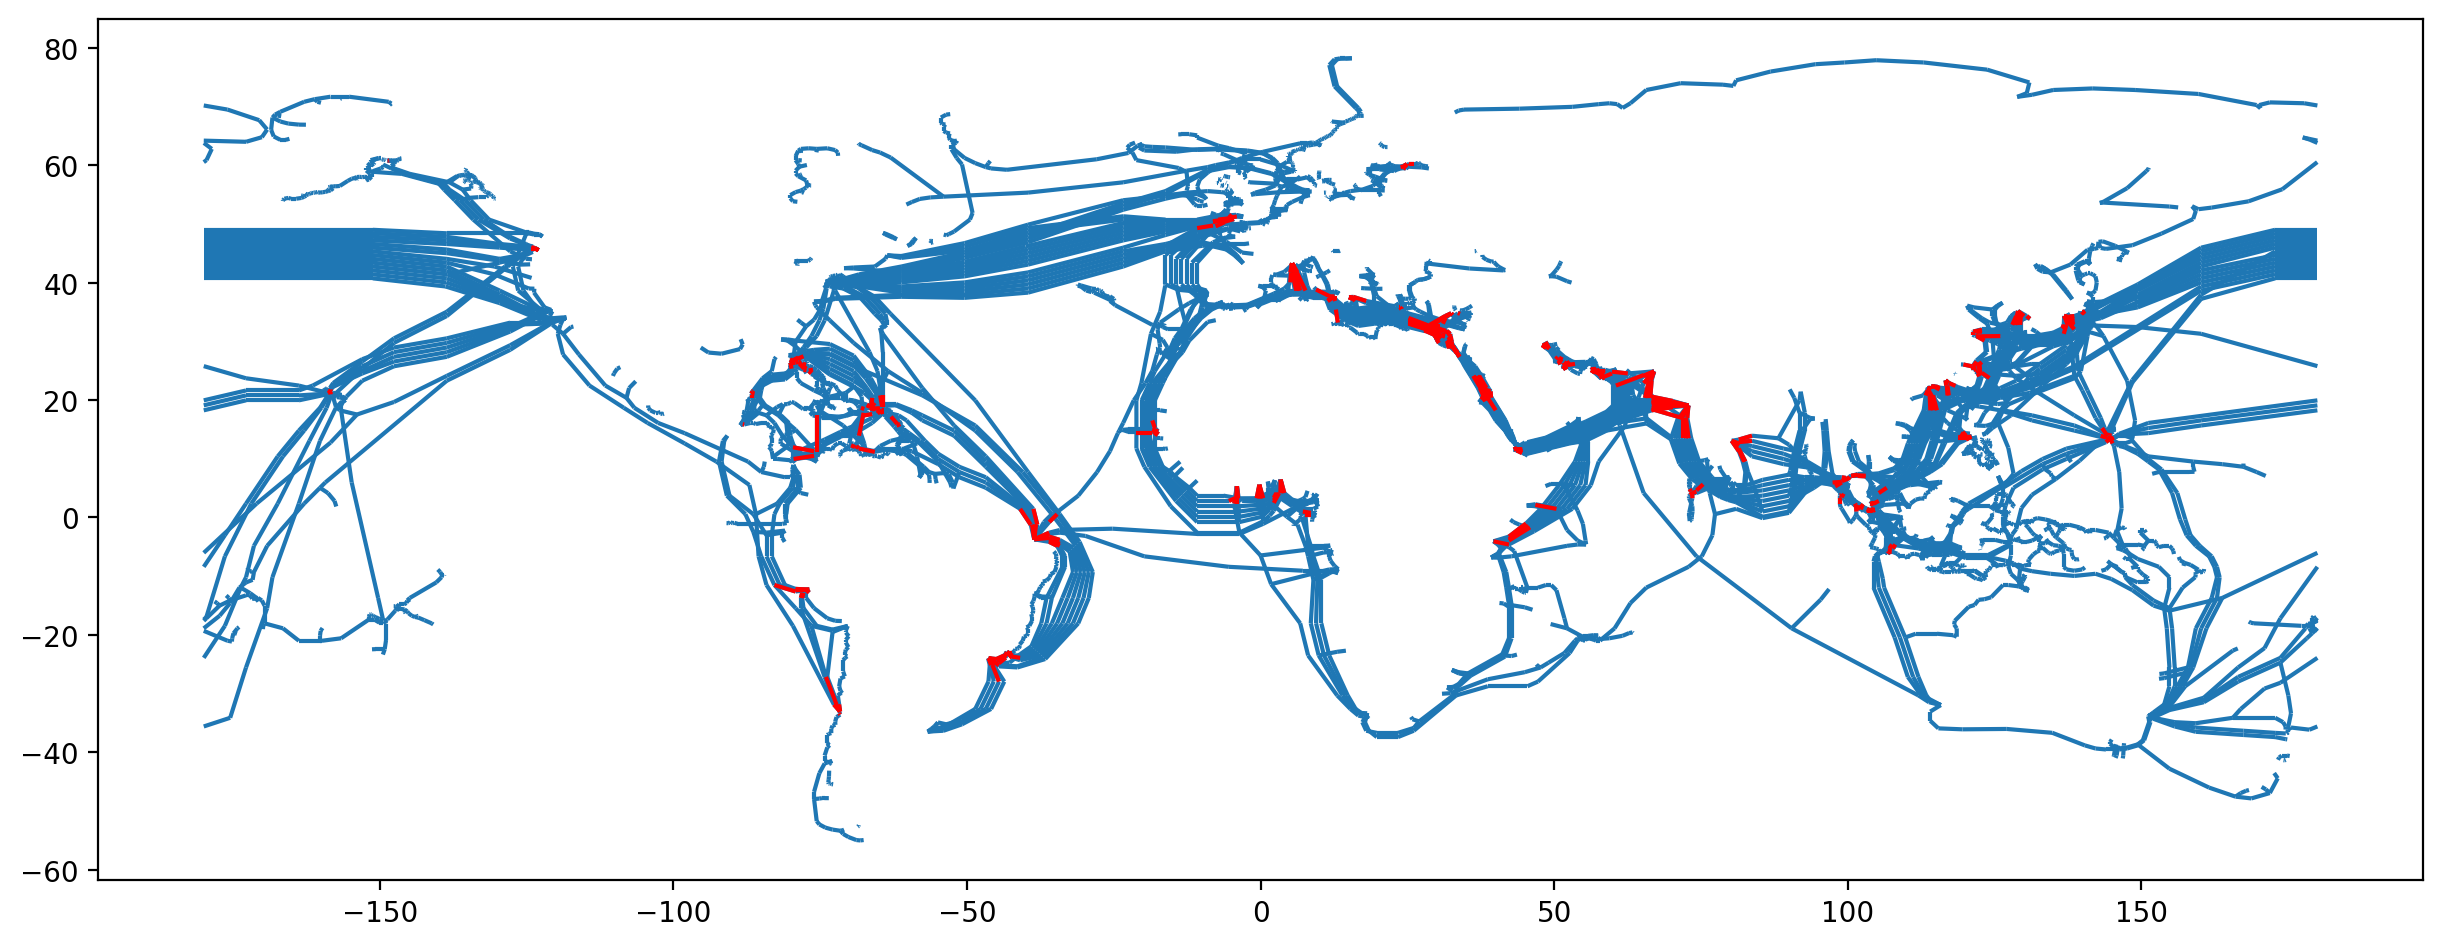

In [90]:
# https://networkx.org/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.assortativity.average_degree_connectivity.html#networkx.algorithms.assortativity.average_degree_connectivity
temp = {}
for key, value in nx.average_neighbor_degree(G).items():
    if value >= 4:
        temp[key] = value
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
gdf.plot(ax=ax)
gdf[gdf['fr_id'].isin(temp.keys()) ].plot(ax = ax, color='red')

In [74]:
# T = nx.minimum_spanning_tree(G, algorithm='kruskal')  # 返回包括最小生成树的图


# path_road = getPath(list (T), gdf)

# fig     = plt.figure(figsize=(15,10),dpi = 200)
# ax      = plt.subplot(111)
# gdf.plot(ax=ax)
# path_road.plot(ax = ax, color='red')

In [81]:
T = nx.minimum_edge_cut(G)

NetworkXError: Input graph is not connected

In [140]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    landingPoint_connection = pd.read_sql("select count(*) as neighborCount, landingPoint_id, landingPoint_name, landingPoint_country, landingPoint_longitude, landingPoint_latitude from landing_points group by landingPoint_id having neighborCount >= 3",con=con)
    landingPoint = pd.read_sql("select * from landing_points",con=con)


landingPoint_connection_gdf = gpd.GeoDataFrame(landingPoint_connection, geometry=gpd.points_from_xy(x=landingPoint_connection['landingPoint_longitude'],y=landingPoint_connection['landingPoint_latitude']))

landingPoint_gdf = gpd.GeoDataFrame(landingPoint, geometry=gpd.points_from_xy(x=landingPoint['landingPoint_longitude'],y=landingPoint['landingPoint_latitude']))
# landingPoint_connection_gdf.plot()


# for x,y,price in zip(scatter_se.lon,scatter_se.lat,scatter_se['实用单价']):
#     hk_map.scatter(x,y,s=price/500,color='#FFEB3B',alpha=.5,ec='k',lw=.1)

In [117]:
# ax = gplt.polyplot(df=nyc_boroughs,
#                    projection=gcrs.AlbersEqualArea())
 
# # 叠加核密度图层
# ax = gplt.kdeplot(df=nyc_collision_factors,
#                   cmap='Reds',
#                   shade=True,
#                   shade_lowest=True,
#                   clip=nyc_boroughs,
#                   ax=ax)
 
# plt.savefig("图6.png", bbox_inches='tight', pad_inches=0, dpi=300)
landingPoint_connection_gdf

,neighborCount,landingPoint_id,landingPoint_name,landingPoint_country,landingPoint_longitude,landingPoint_latitude,geometry
0,6,abidjan-cte-divoire,"Abidjan, Côte d'Ivoire",Côte d'Ivoire,-4.026253,5.323494,POINT (-4.02625 5.32349)
1,6,abu-talat-egypt,"Abu Talat, Egypt",Egypt,29.702495,31.071849,POINT (29.70249 31.07185)
2,6,accra-ghana,"Accra, Ghana",Ghana,-0.200914,5.558502,POINT (-0.20091 5.55850)
3,4,al-khobar-saudi-arabia,"Al Khobar, Saudi Arabia",Saudi Arabia,50.214262,26.286558,POINT (50.21426 26.28656)
4,4,al-seeb-oman,"Al Seeb, Oman",Oman,58.176107,23.684700,POINT (58.17611 23.68470)
...,...,...,...,...,...,...,...
102,5,wall-township-nj-united-states,"Wall Township, NJ, United States",United States,-74.062874,40.152887,POINT (-74.06287 40.15289)
103,6,willemstad-curaao,"Willemstad, Curaçao",Curaçao,-68.896605,12.095319,POINT (-68.89661 12.09532)
104,5,yanbu-saudi-arabia,"Yanbu, Saudi Arabia",Saudi Arabia,38.107016,24.070617,POINT (38.10702 24.07062)
105,7,yeroskipos-cyprus,"Yeroskipos, Cyprus",Cyprus,32.466688,34.766628,POINT (32.46669 34.76663)


In [141]:
world_map = folium.Map()
heatdata = landingPoint[['landingPoint_latitude','landingPoint_longitude']].values.tolist()

HeatMap(heatdata).add_to(world_map)



neighborCount=landingPoint_connection_gdf["neighborCount"]
lon=landingPoint_connection_gdf["landingPoint_longitude"]
lat=landingPoint_connection_gdf["landingPoint_latitude"]
num=neighborCount.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(neighborCount[i]),location=[lat[i],lon[i]],color="yellow",fill=True,fill_color="red",fill_opacity=0.7).add_to(world_map)


world_map

In [134]:
type (lon)

pandas.core.series.Series